In [ ]:
import datetime
import warnings
import pickle
import gc
import os
import math
import pprint

from google.colab import drive, files

In [ ]:
import numpy  as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

In [1]:
# json = files.upload()

In [2]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle competitions download -c nyc-taxi-trip-duration
# !unzip '*.zip'

In [5]:
df_train = pd.read_csv('train.csv')
df_test  = pd.read_csv('test.csv')

print('train: ', df_train.shape)
print('test:  ', df_test.shape)

_TARGET      = 'trip_duration'
_NON_FEATURE = set(df_train.columns) - set(df_test.columns)
_FEATURES    = set(df_train.columns).intersection(set(df_test.columns)) - set(['id'])

train:  (1458644, 11)
test:   (625134, 9)


In [ ]:
sample = df_train[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', _TARGET]].sample(12345)

X = sample[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']]
y = sample[[_TARGET]]

# Linear Regression

Regressao Linear: $y(x) = w^T \phi(x) $

Generalizacao e conexao com a abordagem probabilistica

$$ p(y | x, \theta) = \mathcal{N}(y | w^T \phi(x), \sigma^2(x)) $$

Usando Bayes

$$ Posterior = \frac{ \text{Likelihood} \times \text{Prior} }{ \text{Evidence} } $$

<br/>

$$ \boxed{ p(y | x, \theta) \propto  p(y|\theta,x)p(\theta|x) } $$

Nessa forma a regressao e definida como um modelo discriminativo ([1](https://stats.stackexchange.com/questions/285891/regression-vs-classification-and-generative-vs-discriminative), [2](https://stats.stackexchange.com/questions/12421/generative-vs-discriminative?rq=1) ). Com prior uniforme a equacao anterior assume a forma da regressao linear usual.

Aplicando o MLE na log likelihood 

$$
\begin{aligned}
\mathcal{L}(\theta) &= log \sum_i p(y_i | x_i, \theta) = -\frac{1}{2\sigma^2} \\                      &= \sum_i (y_i - w^T\phi(x_i))^2 - \frac{N}{2}log(2 \pi \sigma^2)
\end{aligned}
$$ 

leva a

$$ \boxed{\hat{w} = (X^T X)^{-1} ) X^Ty} $$

onde $X^T X$ e a matriz $\sum_i x_i x_i^T$.

**PROS.**

+ solucao exata

**CONS.**

+ underfitting devido a outliers (solucao: trocar a likelihood por uma student ou laplace que possui caudas mais pesadas de modo que outliers passam a perturbar menos a curva).
+ overfitting (solucao: trocar MLE por MAP e atribuir uma prior para os parametros).

**F.A.Q.**


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_absolute_error

linreg = LinearRegression(fit_intercept=True)
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
display( mean_absolute_error( y, linreg.predict(X) ) )

560.5718792880024

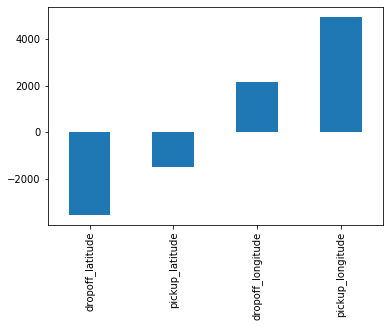

In [51]:
pd.Series(linreg.coef_.flatten(), X.columns.values.flatten()).sort_values().plot(kind='bar')

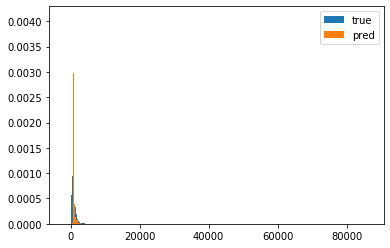

In [76]:
fig, ((ax1)) = plt.subplots(ncols=1, nrows=1)
ax1.hist(y.values,          bins=250, density=True, label='true')
ax1.hist(linreg.predict(X), bins=250, density=True, label='pred')

plt.legend();

# Polynomial Regression

In [78]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_absolute_error

d = 3
polyreg = PolynomialFeatures(degree=d)
x_poly  = polyreg.fit_transform(X)

linreg_p  = LinearRegression(fit_intercept=True)
linreg_p.fit(x_poly,  y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
display( mean_absolute_error( y, linreg_p.predict(x_poly) ) )

464.04132911277327

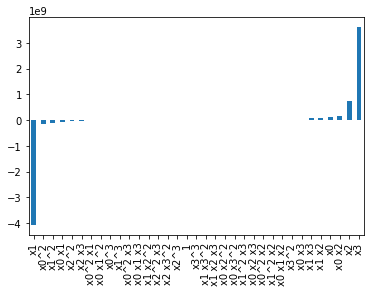

In [84]:
pd.Series(linreg_p.coef_.flatten(), polyreg.get_feature_names()).sort_values().plot(kind='bar')

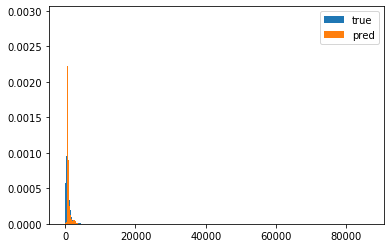

In [86]:
fig, ((ax1)) = plt.subplots(ncols=1, nrows=1)
ax1.hist(y.values,          bins=250, density=True, label='true')
ax1.hist(linreg_p.predict(x_poly), bins=250, density=True, label='pred')

plt.legend();

# Ridge, Lasso and Elastic-Net Regression

comparacoes entre os 3 metodos de regularizacao ( [1](https://blog.alexlenail.me/what-is-the-difference-between-ridge-regression-the-lasso-and-elasticnet-ec19c71c9028), [2](http://www.sthda.com/english/articles/37-model-selection-essentials-in-r/153-penalized-regression-essentials-ridge-lasso-elastic-net/),  [3](https://stats.stackexchange.com/questions/93181/ridge-lasso-and-elastic-net))

**Ridge** tambem possui solucao exata

$$ \boxed{\hat{w} = (\lambda I +  X^T X)^{-1} ) X^Ty} $$

+ Pode ser estabelecida relacao entre ridge regression e pca regression ([1](https://stats.stackexchange.com/questions/81395/relationship-between-ridge-regression-and-pca-regression), [2](https://nirpyresearch.com/pcr-vs-ridge-regression-nir-data-python/)). Na pratica RR tende a ter acuracia preditiva maior e PCAR atua na reducao de dimensionalidade.

**PROS**

+ possui solucao exata
+ controle de complexidade do modelo via parametro de regularizacao (portanto controle de overfitting).

**CONS**

- - -

**LASSO**

produz solucoes esparsas ([1](https://stats.stackexchange.com/questions/267322/difference-between-missing-data-and-sparse-data-in-machine-learning-algorithms))

**CONS**



Mesma estrutura para ambos os métodos `Ridge`, `Lasso`, `ElasticNet`.

In [92]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model    import Ridge
from sklearn.metrics         import mean_absolute_error

ridge_cv   = GridSearchCV(Ridge(fit_intercept=True), {'alpha': [2.37**i for i in range(-8, 8)]}, scoring='neg_mean_absolute_error', cv=5)
ridge_cv.fit(X, y)
print(ridge_cv.best_params_['alpha'])

0.0010046463989966537


In [93]:
ridreg = Ridge( alpha=ridge_cv.best_params_['alpha'], fit_intercept=True )
ridreg.fit(X, y)

Ridge(alpha=0.0010046463989966537, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='auto',
      tol=0.001)

In [94]:
display( mean_absolute_error( y, ridreg.predict(X) ) )

560.5727157918019

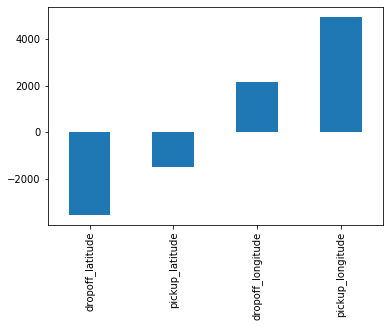

In [95]:
pd.Series(ridreg.coef_.flatten(), X.columns.values.flatten()).sort_values().plot(kind='bar')

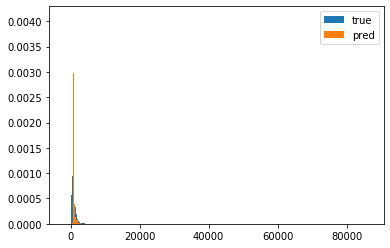

In [98]:
fig, ((ax1)) = plt.subplots(ncols=1, nrows=1)
ax1.hist(y.values,          bins=250, density=True, label='true')
ax1.hist(ridreg.predict(X), bins=250, density=True, label='pred')

plt.legend();

In [97]:
ridreg.coef_

array([[-1504.818311  ,  4957.5702127 , -3548.85373822,  2142.69244859]])